In [1]:
import os
import glob
from nilearn import image
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import nibabel as nib
from nilearn import plotting
from nilearn import datasets
import scipy.io
from scipy import stats
from copy import deepcopy
import time
import nibabel as nib
import sklearn
import nibabel
from nibabel import processing
import matplotlib.colors as colors
from scipy import stats
import random
import pandas as pd
from nilearn import datasets
from nilearn.glm import cluster_level_inference
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from nilearn.glm import threshold_stats_img
from nilearn.reporting import get_clusters_table
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import index_img

In [4]:
#read in grey matter mask
file='../rois/glm_mask_gm.nii.gz'
gm_mask_nii = nib.load(file)
affine = gm_mask_nii.affine
gm_mask_data = gm_mask_nii.get_fdata(dtype=np.float32)  # or use np.uint8 to preserve binary

## Second-level inference with cluster-level correction

### pupil parametric regressor

In [43]:
#read in files
with open('../analyses/subjects-pupil-fmri.txt', 'r') as file:
    included_subjects = set(line.strip() for line in file)
len(included_subjects)

file_pattern = os.path.join("./subjects_glm_maps/pupil/", '*.nii.gz')
files = sorted(glob.glob(file_pattern))

filtered_files = [
    f for f in files
    if os.path.basename(f).split('_')[0] in included_subjects
]

subject_ids = [os.path.basename(f).split('_')[0] for f in filtered_files]
subject_files = {}
for f in files:
    basename = os.path.basename(f)
    subject_id = basename.split('_')[0]  # Extract the subject ID
    if subject_id in included_subjects:
        if subject_id not in subject_files:
            subject_files[subject_id] = []
        subject_files[subject_id].append(f)
        
#Extract the 28th volume (index 27) — z-score for pupil
subject_ids = [os.path.basename(f).split('_')[0] for f in filtered_files]

pupil_z_maps = []
for f in filtered_files:
    tmpimg = index_img(f, 27)
    tempdata = tmpimg.get_fdata()
    tempdata[np.round(tempdata,17)==0]=0 #the 0s were recognized as 1e-18 which created the problem
    tmpimg = nib.Nifti1Image(tempdata, affine)
    pupil_z_maps.append(tmpimg)

In [44]:
# Step 1: Build design matrix for one-sample t-test
design_matrix = pd.DataFrame(
    [1] * len(filtered_files),
    columns=["intercept"],
)

# Step 2: Fit second-level GLM (no smoothing — already smoothed)
pupil_group_model = SecondLevelModel(smoothing_fwhm=None, mask_img=gm_mask_nii)
pupil_group_model = pupil_group_model.fit(pupil_z_maps, design_matrix=design_matrix)

pupil_z_map = pupil_group_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="z_score",
)

pupil_z_map_data = pupil_z_map.get_fdata()
# pupil_z_map_data = pupil_z_map_data * gm_mask_data
# pupil_z_map = nib.Nifti1Image(pupil_z_map_data, affine)

-5.089404363361032 5.133578959767593


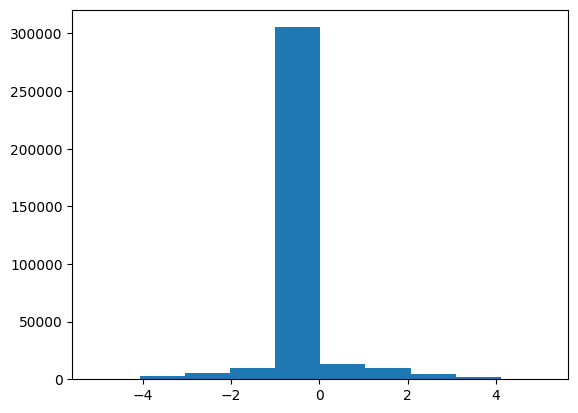

In [8]:
plt.hist(pupil_z_map.get_fdata().flatten())
print(pupil_z_map.get_fdata().min(),pupil_z_map.get_fdata().max())

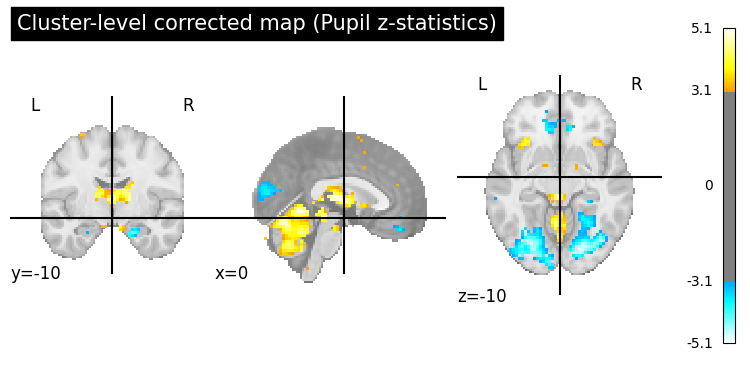

In [9]:
# plot it with a z=3.1 threshold
plotting.plot_stat_map(pupil_z_map, threshold=3.1,cut_coords=[0,-10,-10],
                       title="Cluster-level corrected map (Pupil z-statistics)")

## non-parametric test (permutation)

In [45]:
#Next, we compute the (corrected) p-values with a parametric test to compare them with the results from a nonparametric test.
from nilearn.image import get_data, math_img

p_val = pupil_group_model.compute_contrast(output_type="p_value")
n_voxels = np.sum(get_data(pupil_group_model.masker_.mask_img_))
# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    f"-np.log10(np.minimum(1, img * {n_voxels!s}))",
    img=p_val,
)

# Now, we compute the (corrected) p-values with a permutation test.
num_of_permutation = 10000
# We will use non_parametric_inference for this step, although permuted_ols could be used as well (pending additional steps to mask and reformat the inputs).
from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    pupil_z_maps,
    design_matrix=design_matrix,
    model_intercept=True,
    n_perm=num_of_permutation,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    threshold=0.01, #cluster-forming threshold
    smoothing_fwhm=None,
    n_jobs=2,
    mask=gm_mask_nii
)

<string>:1: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/mass_univariate/permuted_least_squares.py:671: UserWarning: Some descriptors in 'target_vars' have zeros across all samples. These descriptors will be ignored during null distribution generation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/mass_univariate/_utils.py:328: RuntimeWarning: invalid value encountered in divide
  ret = (m.T / np.sqrt(np.sum(m**2, axis=0))[:, np.newaxis]).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has be

++ 3drefit: AFNI version=AFNI_24.1.02 (Apr 14 2024) [64-bit]
++ Authored by: RW Cox
** AFNI converts NIFTI_datatype=8 (INT32) in file /Users/yanyan/Desktop/midaffemo/glm_maps/pupil_zmap_cluster_size.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Processing AFNI dataset pupil_zmap_cluster_size.nii.gz
*+ WARNING: Changing the space of an ORIG view dataset may cause confusion!
*+ WARNING:  NIFTI copies will be interpreted as TLRC view (not TLRC space).
*+ WARNING:  Consider changing the view of the dataset to TLRC view also
 + loading and re-writing dataset pupil_zmap_cluster_size.nii.gz (/Users/yanyan/Desktop/midaffemo/glm_maps/pupil_zmap_cluster_size.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets
++ 3drefit: AFNI version=AFNI_24.1.02 (Apr 14 2024) [64-bit]
++ Authored by: RW Cox
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /Users/yanyan/Desktop/midaffemo/glm_maps/pupi

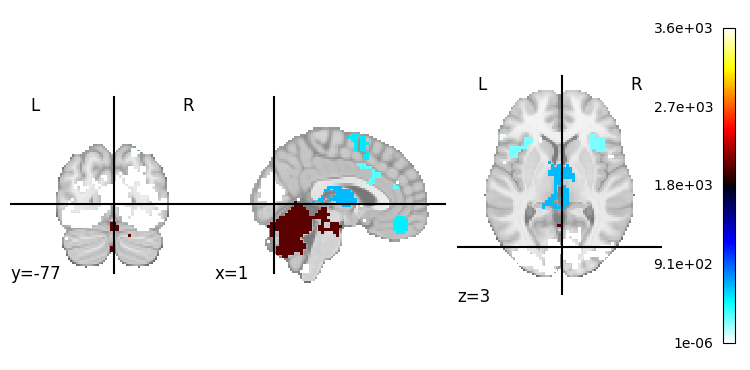

In [46]:
plotting.plot_stat_map(out_dict['size'])


nib.save(out_dict['size'], 'pupil_zmap_cluster_size.nii.gz')
nib.save(out_dict['logp_max_size'], 'pupil_zmap_logp_max_size.nii.gz')
nib.save(out_dict['logp_max_mass'], 'pupil_zmap_logp_max_mass.nii.gz')
nib.save(out_dict['logp_max_t'], 'pupil_zmap_logp_max_t.nii.gz')

!3drefit -space MNI pupil_zmap_cluster_size.nii.gz
!3drefit -space MNI pupil_zmap_logp_max_size.nii.gz
!3drefit -space MNI pupil_zmap_logp_max_mass.nii.gz
!3drefit -space MNI pupil_zmap_logp_max_t.nii.gz

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/plotting/img_plotting.py:1283: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


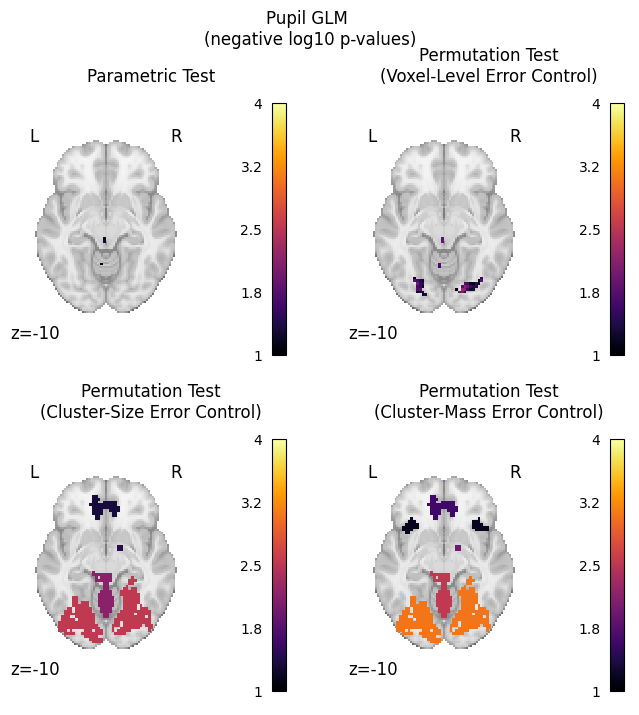

In [47]:
import itertools

threshold = 1  # negative log10 threshold of p < 0.1
#We will use a negative log10 p threshold of 1, which corresponds to p<0.1. This threshold indicates that there is less 
#than 10% probability to make a single false discovery (90% chance that we make no false discovery at all). This threshold 
#is much more conservative than an uncorrected threshold, but is still more liberal than a typical corrected threshold for 
#this kind of analysis, which tends to be ~0.05.

vmax = -np.log10(1 / num_of_permutation)  # ~= -np.log10(1 / 500)
#We will also cap the negative log10 p-values at 2.69, because this is the maximum observable value for 
#the nonparametric tests, which were run with only 500 permutations.
cut_coords = [0]

IMAGES = [
    neg_log_pval,
    out_dict["logp_max_t"],
    out_dict["logp_max_size"],
    out_dict["logp_max_mass"],
]
TITLES = [
    "Parametric Test",
    "Permutation Test\n(Voxel-Level Error Control)",
    "Permutation Test\n(Cluster-Size Error Control)",
    "Permutation Test\n(Cluster-Mass Error Control)",
]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)
for img_counter, (i_row, j_col) in enumerate(
    itertools.product(range(2), range(2))
):
    ax = axes[i_row, j_col]
    plotting.plot_stat_map(
        IMAGES[img_counter],
        vmax=vmax,
        vmin=threshold,
        display_mode="z",
        cut_coords=[-10],
        threshold=threshold,
        figure=fig,
        axes=ax,
        cmap="inferno",
    )
    ax.set_title(TITLES[img_counter])
fig.suptitle("Pupil GLM \n(negative log10 p-values)")
plt.show()

In [233]:
pupil_z_map.to_filename('second_level_cluster_corrected_pupil_zmap.nii.gz')
!3drefit -space MNI second_level_cluster_corrected_pupil_zmap.nii.gz

++ 3drefit: AFNI version=AFNI_24.1.02 (Apr 14 2024) [64-bit]
++ Authored by: RW Cox
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /Users/yanyan/Desktop/midaffemo/glm_maps/second_level_cluster_corrected_pupil_zmap.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Processing AFNI dataset second_level_cluster_corrected_pupil_zmap.nii.gz
*+ WARNING: Changing the space of an ORIG view dataset may cause confusion!
*+ WARNING:  NIFTI copies will be interpreted as TLRC view (not TLRC space).
*+ WARNING:  Consider changing the view of the dataset to TLRC view also
 + loading and re-writing dataset second_level_cluster_corrected_pupil_zmap.nii.gz (/Users/yanyan/Desktop/midaffemo/glm_maps/second_level_cluster_corrected_pupil_zmap.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets


In [50]:
## creat binary mask based on the cluster-based permutation results
cluster_correct_mask=out_dict["logp_max_mass"].get_fdata()
cluster_correct_mask[cluster_correct_mask>threshold]=1
cluster_correct_mask[cluster_correct_mask!=1]=0
cluster_correct_zmap = pupil_z_map_data*cluster_correct_mask
cluster_correct_zmap=nib.Nifti1Image(cluster_correct_zmap,affine=affine)

plotting.view_img(cluster_correct_zmap)

table = get_clusters_table(cluster_correct_zmap, stat_threshold=0.01, two_sided=True)
print(table)
table.to_csv("../cluster_table/tables/table_model33b_nilearn.csv", index=False)


nib.save(cluster_correct_zmap, 'cluster_correct_zmap_pupil.nii.gz')
!3drefit -space MNI cluster_correct_zmap_pupil.nii.gz

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


   Cluster ID          X          Y          Z  Peak Stat Cluster Size (mm3)
0           1  -1.449998 -19.449999  10.400000   5.133579              15804
1          1a -10.149999  -4.949999  10.400000   4.832301                   
2          1b  15.950002 -10.749999  10.400000   4.667187                   
3          1c  -4.349998 -31.050000   4.599999   4.613162                   
4           2  -1.449998 -51.350000  -4.100001   5.089378              49899
5          2a   7.250002 -13.649999 -21.500001   4.956738                   
6          2b  -1.449998 -68.750001 -15.700001   4.860421                   
7          2c  -1.449998 -31.050000  -9.900001   4.765457                   
8           3 -39.150000  12.450002  10.400000   4.886803               5999
9          3a -33.349999  21.150002 -12.800001   4.151576                   
10         3b -30.449999  18.250002  10.400000   3.901949                   
11         3c -39.150000  18.250002  -4.100001   3.544740                   

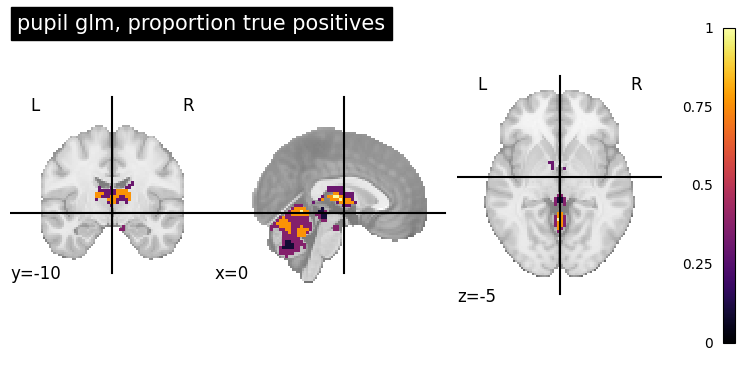

In [236]:
#count the proportion of significant voxels under different threshold (UNCORRECTED)
from scipy.stats import norm

p_val = 0.01
p001_uncorrected = norm.isf(p_val)

from nilearn.glm import cluster_level_inference

proportion_true_discoveries_img = cluster_level_inference(
    pupil_z_map, threshold=[3, 4, 5], alpha=0.05
)

plotting.plot_stat_map(
    proportion_true_discoveries_img,
    threshold=0.0,
    cut_coords=[0,-10,-5],
    vmax=1,
    cmap="inferno",
    title="pupil glm, proportion true positives",
)

### self-reported arousal parametric regressor

In [31]:
#read in files
with open('../analyses/subjects-midaffemo-included.txt', 'r') as file:
    included_subjects = set(line.strip() for line in file)
len(included_subjects)

file_pattern = os.path.join("./subjects_glm_maps/self_report/", '*mni.nii.gz')
files = sorted(glob.glob(file_pattern))

filtered_files = [
    f for f in files
    if os.path.basename(f).split('_')[0] in included_subjects
]

subject_ids = [os.path.basename(f).split('_')[0] for f in filtered_files]
subject_files = {}
for f in files:
    basename = os.path.basename(f)
    subject_id = basename.split('_')[0]  # Extract the subject ID
    if subject_id in included_subjects:
        if subject_id not in subject_files:
            subject_files[subject_id] = []
        subject_files[subject_id].append(f)
        
#Extract the 28th volume (index 27) — z-score for pupil
subject_ids = [os.path.basename(f).split('_')[0] for f in filtered_files]

selfreport_z_maps = []
for f in filtered_files:
    tmpimg = index_img(f, 27)
    tempdata = tmpimg.get_fdata()
    tempdata[np.round(tempdata,17)==0]=0 #the 0s were recognized as 1e-18 which created the problem
    tmpimg = nib.Nifti1Image(tempdata, affine)
    selfreport_z_maps.append(tmpimg)

In [32]:
# Step 1: Build design matrix for one-sample t-test
design_matrix = pd.DataFrame(
    [1] * len(filtered_files),
    columns=["intercept"],
)

# Step 2: Fit second-level GLM (no smoothing — already smoothed)
selfreport_group_model = SecondLevelModel(smoothing_fwhm=None,mask_img=gm_mask_nii)
selfreport_group_model = selfreport_group_model.fit(selfreport_z_maps, design_matrix=design_matrix)

selfreport_z_map = selfreport_group_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="z_score",
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


(array([1.70000e+01, 2.89000e+02, 1.47400e+03, 4.67700e+03, 3.02356e+05,
        1.72100e+04, 1.59310e+04, 9.05800e+03, 2.43300e+03, 1.55000e+02]),
 array([-3.6088723 , -2.77888011, -1.94888791, -1.11889572, -0.28890352,
         0.54108867,  1.37108086,  2.20107306,  3.03106525,  3.86105745,
         4.69104964]),
 <BarContainer object of 10 artists>)

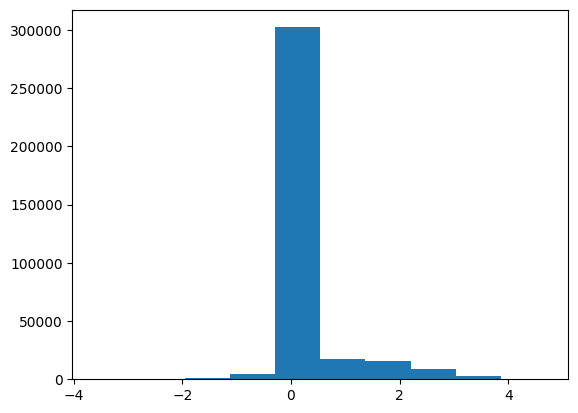

In [33]:
plt.hist(selfreport_z_map.get_fdata().flatten())

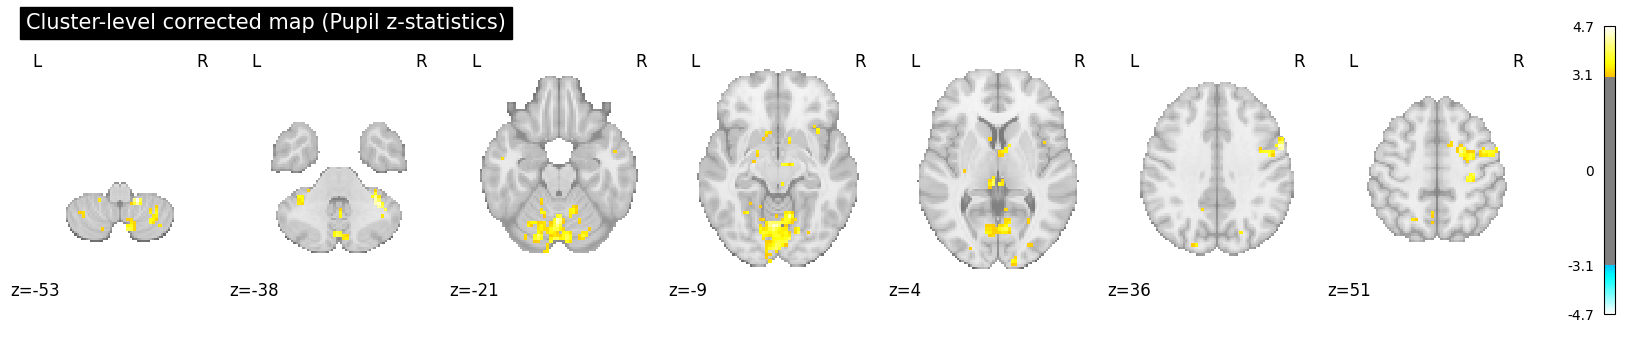

In [34]:

# plot it with a z=3.1 threshold
plotting.plot_stat_map(selfreport_z_map, threshold=3.1, display_mode='z', cut_coords=7,
                       title="Cluster-level corrected map (Pupil z-statistics)")

## non-parametric test (permutation)

In [35]:
#Next, we compute the (corrected) p-values with a parametric test to compare them with the results from a nonparametric test.
from nilearn.image import get_data, math_img

p_val = selfreport_group_model.compute_contrast(output_type="p_value")
n_voxels = np.sum(get_data(selfreport_group_model.masker_.mask_img_))
# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    f"-np.log10(np.minimum(1, img * {n_voxels!s}))",
    img=p_val,
)

# Now, we compute the (corrected) p-values with a permutation test.
num_of_permutation = 10000
# We will use non_parametric_inference for this step, although permuted_ols could be used as well (pending additional steps to mask and reformat the inputs).
from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    selfreport_z_maps,
    design_matrix=design_matrix,
    model_intercept=True,
    n_perm=num_of_permutation, 
    two_sided_test=True,
    threshold=0.01, #cluster-forming threshold
    smoothing_fwhm=None,
    n_jobs=2,
    mask=gm_mask_nii
)

<string>:1: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/mass_univariate/permuted_least_squares.py:671: UserWarning: Some descriptors in 'target_vars' have zeros across all samples. These descriptors will be ignored during null distribution generation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/mass_univariate/_utils.py:328: RuntimeWarning: invalid value encountered in divide
  ret = (m.T / np.sqrt(np.sum(m**2, axis=0))[:, np.newaxis]).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has be

++ 3drefit: AFNI version=AFNI_24.1.02 (Apr 14 2024) [64-bit]
++ Authored by: RW Cox
** AFNI converts NIFTI_datatype=8 (INT32) in file /Users/yanyan/Desktop/midaffemo/glm_maps/selfReportedArousal_zmap_cluster_size.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Processing AFNI dataset selfReportedArousal_zmap_cluster_size.nii.gz
*+ WARNING: Changing the space of an ORIG view dataset may cause confusion!
*+ WARNING:  NIFTI copies will be interpreted as TLRC view (not TLRC space).
*+ WARNING:  Consider changing the view of the dataset to TLRC view also
 + loading and re-writing dataset selfReportedArousal_zmap_cluster_size.nii.gz (/Users/yanyan/Desktop/midaffemo/glm_maps/selfReportedArousal_zmap_cluster_size.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets
++ 3drefit: AFNI version=AFNI_24.1.02 (Apr 14 2024) [64-bit]
++ Authored by: RW Cox
** AFNI converts NIFTI_datatype=64 (FLOAT6

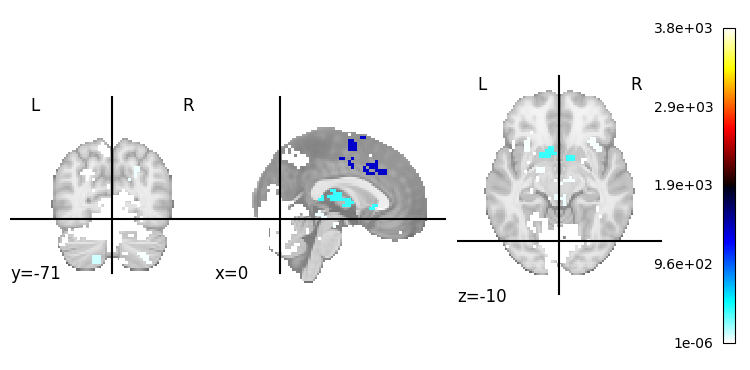

In [246]:
plotting.plot_stat_map(out_dict['size'])


nib.save(out_dict['size'], 'selfReportedArousal_zmap_cluster_size.nii.gz')
nib.save(out_dict['logp_max_size'], 'selfReportedArousal_zmap_logp_max_size.nii.gz')
nib.save(out_dict['logp_max_mass'], 'selfReportedArousal_zmap_logp_max_mass.nii.gz')
nib.save(out_dict['t'], 'selfReportedArousal_zmap_t.nii.gz')

!3drefit -space MNI selfReportedArousal_zmap_cluster_size.nii.gz
!3drefit -space MNI selfReportedArousal_zmap_logp_max_size.nii.gz
!3drefit -space MNI selfReportedArousal_zmap_logp_max_mass.nii.gz
!3drefit -space MNI selfReportedArousal_zmap_t.nii.gz

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nilearn/plotting/img_plotting.py:1283: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


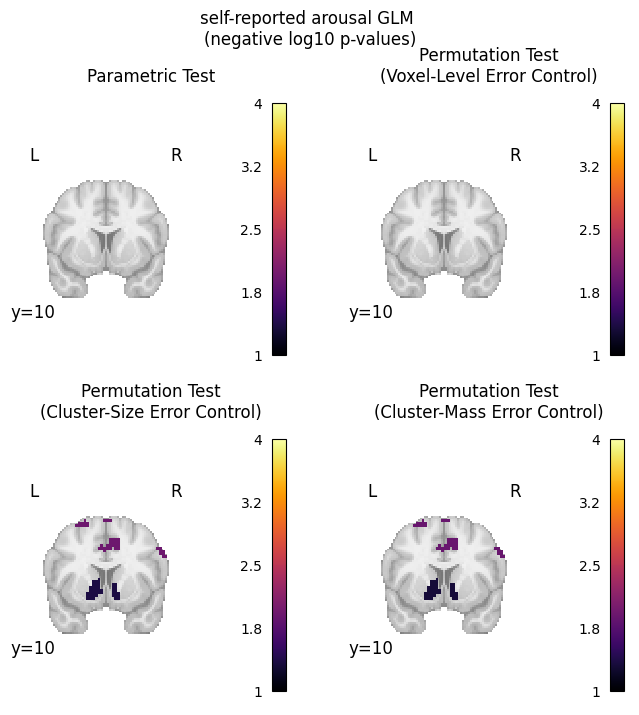

In [36]:
import itertools

threshold = 1  # negative log10 threshold of p < 0.05
#We will use a negative log10 p threshold of 1, which corresponds to p<0.1. This threshold indicates that there is less 
#than 10% probability to make a single false discovery (90% chance that we make no false discovery at all). This threshold 
#is much more conservative than an uncorrected threshold, but is still more liberal than a typical corrected threshold for 
#this kind of analysis, which tends to be ~0.05.

vmax = -np.log10(1 / num_of_permutation)  # ~= -np.log10(1 / 500)
#We will also cap the negative log10 p-values at 2.69, because this is the maximum observable value for 
#the nonparametric tests, which were run with only 500 permutations.
cut_coords = [0]

IMAGES = [
    neg_log_pval,
    out_dict["logp_max_t"],
    out_dict["logp_max_size"],
    out_dict["logp_max_mass"],
]
TITLES = [
    "Parametric Test",
    "Permutation Test\n(Voxel-Level Error Control)",
    "Permutation Test\n(Cluster-Size Error Control)",
    "Permutation Test\n(Cluster-Mass Error Control)",
]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)
for img_counter, (i_row, j_col) in enumerate(
    itertools.product(range(2), range(2))
):
    ax = axes[i_row, j_col]
    plotting.plot_stat_map(
        IMAGES[img_counter],
        vmax=vmax,
        vmin=threshold,
        display_mode="y",
        cut_coords=[10],
        threshold=threshold,
        figure=fig,
        axes=ax,
        cmap="inferno",
    )
    ax.set_title(TITLES[img_counter])
fig.suptitle("self-reported arousal GLM \n(negative log10 p-values)")
plt.show()

In [37]:
pupil_z_map.to_filename('second_level_cluster_corrected_selfReportedArousal_zmap.nii.gz')
!3drefit -space MNI second_level_cluster_corrected_selfReportedArousal_zmap.nii.gz

++ 3drefit: AFNI version=AFNI_24.1.02 (Apr 14 2024) [64-bit]
++ Authored by: RW Cox
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /Users/yanyan/Desktop/midaffemo/glm_maps/second_level_cluster_corrected_selfReportedArousal_zmap.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Processing AFNI dataset second_level_cluster_corrected_selfReportedArousal_zmap.nii.gz
*+ WARNING: Changing the space of an ORIG view dataset may cause confusion!
*+ WARNING:  NIFTI copies will be interpreted as TLRC view (not TLRC space).
*+ WARNING:  Consider changing the view of the dataset to TLRC view also
 + loading and re-writing dataset second_level_cluster_corrected_selfReportedArousal_zmap.nii.gz (/Users/yanyan/Desktop/midaffemo/glm_maps/second_level_cluster_corrected_selfReportedArousal_zmap.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets


In [39]:
## creat binary mask based on the cluster-based permutation results
selfreport_z_map_data = selfreport_z_map.get_fdata()
cluster_correct_mask=out_dict["logp_max_mass"].get_fdata()
cluster_correct_mask[cluster_correct_mask>threshold]=1
cluster_correct_mask[cluster_correct_mask!=1]=0
cluster_correct_zmap = selfreport_z_map_data*cluster_correct_mask
cluster_correct_zmap=nib.Nifti1Image(cluster_correct_zmap,affine=affine)

plotting.view_img(cluster_correct_zmap)

table = get_clusters_table(cluster_correct_zmap, stat_threshold=0.01, two_sided=True)

print(table)
table.to_csv("../cluster_table/tables/table_model27_nilearn.csv", index=False)

nib.save(cluster_correct_zmap, 'cluster_correct_zmap_arousal.nii.gz')
!3drefit -space MNI cluster_correct_zmap_arousal.nii.gz

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


   Cluster ID          X          Y          Z  Peak Stat Cluster Size (mm3)
0           1  15.950002 -45.550000 -53.400002   4.691050              93409
1          1a  -1.449998 -62.950001 -21.500001   4.502780                   
2          1b  33.350003 -39.750000 -36.000002   4.485501                   
3          1c  36.250003 -48.450000 -38.900002   4.480116                   
4           2  56.550004   3.750001  36.500000   4.486718              33217
5          2a  44.950003  -2.049999  39.400001   4.198970                   
6          2b  21.750002  -2.049999  51.000001   4.151659                   
7          2c  56.550004   0.850001  48.100001   4.105636                   
8           3 -21.749999  21.150002  -1.200001   3.976346               9340
9          3a  -4.349998 -31.050000   4.599999   3.955621                   
10         3b   7.250002   3.750001  -7.000001   3.927168                   
11         3c  -7.249999   9.550002  -1.200001   3.765767                   

/var/folders/q6/h8ld6fr92hj5v7s22m9q32rr0000gn/T/ipykernel_19289/672642668.py:11: UserWarning: Attention: No clusters with stat lower than -0.01
  table = get_clusters_table(cluster_correct_zmap, stat_threshold=0.01, two_sided=True)
